# Logistic Regression

We will show how to use logistic regression to classify whether a case of breast cancer is benign or malignant using the [Wisconsin breast cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)

In [1]:
from itertools import product

import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from mltools.glm import LogisticRegression
from mltools.optimization import GradientDescent, NewtonRaphson
from mltools.preprocessing import Normalizer
from mltools.visualization import pca_label_plot

## Loading the data

The breast cancer dataset imported from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) contains 569 samples with 30 real, positive features (including cancer mass attributes like mean radius, mean texture, mean perimeter, et cetera).
Of the samples, 212 are labeled `"malignant"` and 357 are labeled `"benign"`.
We load this data into a 569×30 feature matrix (`x`) and a 569×1 binary target vector (`y`).
Then we randomly shuffle the data and designate the first half for training and the second half for testing.


In [2]:
data = load_breast_cancer()
x = data.data
y = data.target_names[data.target]

# Relabel the target vector
y[y == "malignant"] = "+"
y[y == "benign"] = "-"

np.random.seed(100)
idx = np.random.permutation(y.size)
x_train, x_test = np.array_split(x[idx], 2)
y_train, y_test = np.array_split(y[idx], 2)

We normalize the data so that each feature has mean 0 and variance 1.

In [3]:
normalizer = Normalizer()
normalizer.fit(x_train)
x_train = normalizer.transform(x_train)
x_test = normalizer.transform(x_test)

## Fitting the logistic regression model

Next, we initialize a `LogisticRegression` object and fit it to the training data using gradient descent.
We use an optional callback function to record the model's weights and average cross entropy loss during each iteration of gradient descent.

In [4]:
%%time
weights = []
loss = []
def callback(weight):
    weights.append(weight)
    loss.append(clf.loss(weight))

gd = GradientDescent(rate=0.7, momentum=0.5, iterations=10000, anneal=2500)
clf = LogisticRegression(penalty=None)
clf.fit(x=x_train, y=y_train, optimizer=gd, callback=callback)

CPU times: user 532 ms, sys: 5.45 ms, total: 537 ms
Wall time: 538 ms


We can track the convergence of the model's training by plotting the average cross entropy loss against the iterations of the training algorithm.

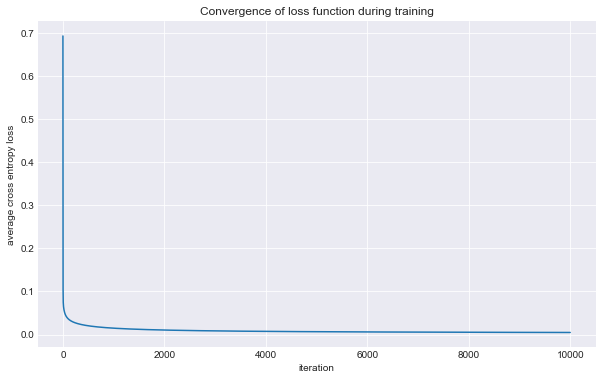

In [5]:
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
plt.plot(np.arange(len(loss)), loss)
plt.xlabel("iteration")
plt.ylabel("average cross entropy loss")
plt.title("Convergence of loss function during training")
plt.show()

We can also track the convergence of the model's weights corresponding to the intercept and the first 15 features.

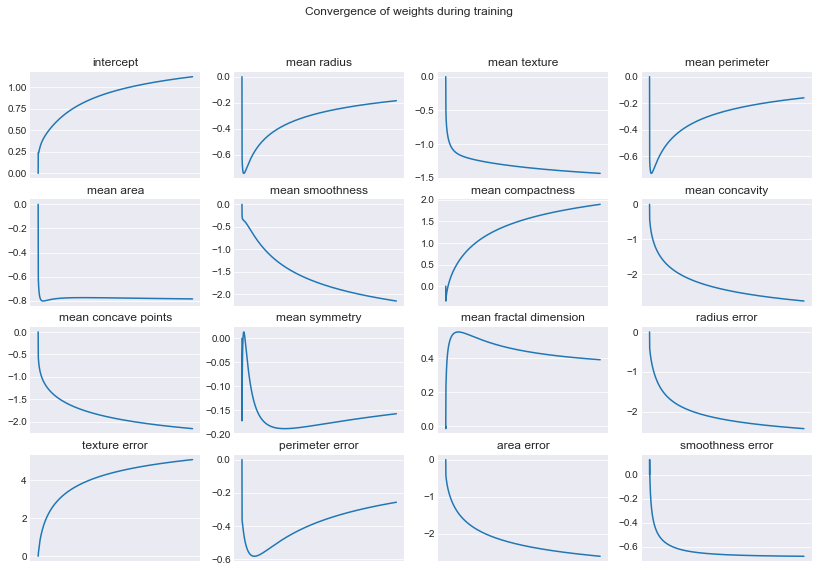

In [6]:
weights = np.asarray(weights)

n_iterations, n_features = weights.shape
nrows = 4
ncols = 4

sns.set_style("darkgrid")
_, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 9))
for i, j in product(range(nrows), range(ncols)):
    k = nrows * i + j
    w = weights[:, k]
    label = "intercept" if k == 0 else data.feature_names[k - 1]
    axes[i, j].plot(np.arange(n_iterations), w, label=label)
    axes[i, j].set_title(label)
    axes[i, j].get_xaxis().set_visible(False)
plt.suptitle("Convergence of weights during training")
plt.show()
plt.close()

## Prediction accuracy

As a first indicator of how well the model predicts the correct labels, we can check its accuracy (number of correct predictions over the number of total predictions) on the training and test data.
If the classifier is good, then the accuracy should be close to 1.

In [7]:
pred_train = clf.predict(x_train)
pred_test = clf.predict(x_test)
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f"Training accuracy: {accuracy_train:.4f}")
print(f"Testing accuracy:  {accuracy_test:.4f}")

Training accuracy: 1.0000
Testing accuracy:  0.9577


## False positive rate, false negative rate, and precision

Another classifier performance metric is the false positive rate and false negative rate of the predictions on the test set.
If the classifier is good, then both rates should be close to 0.

In [8]:
# Compute the confusion matrix of the predictions to extract the indices
# of true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()

# Report the false positive and false negative rates
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
precision = tp / (tp + fp)

print(f"False positive rate: {fpr:.4f}")
print(f"False negative rate: {fnr:.4f}")

False positive rate: 0.0857
False negative rate: 0.0168


## Visualizing the misclassifications

We can plot the first two principal components of the data points and their corresponding predicted label.
A green mark indicates a correct classification, while a red mark indicates a misclassification.

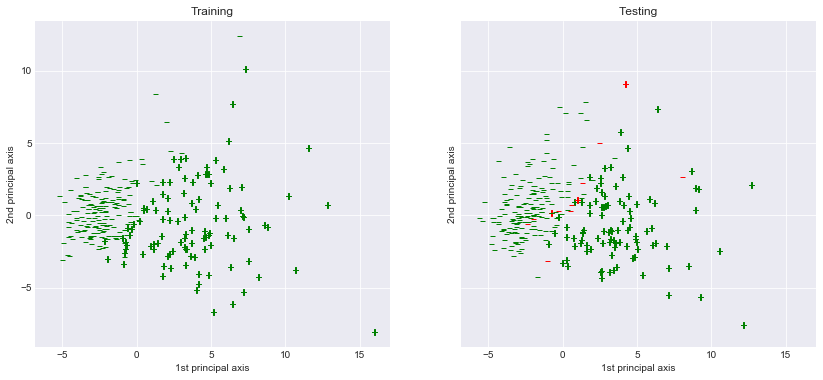

In [9]:
# Plot the labeled training and test data
_, axes = plt.subplots(1, 2, sharex="all", sharey="all", figsize=(14, 6))
_, pca = pca_label_plot(x_train, y_train, pred_train, ax=axes[0])
pca_label_plot(x_test, y_test, pred_test, pca=pca, ax=axes[1])
axes[0].set_title("Training")
axes[1].set_title("Testing")
axes[0].set_xlabel("1st principal axis")
axes[0].set_ylabel("2nd principal axis")
axes[1].set_xlabel("1st principal axis")
plt.show()
plt.close()

## Improving model generalization using $L^2$ regularization

Our model is a perfect classifier on the training set, but it performs significantly worse on the testing data.
This problem is called overfitting, meaning that our model will not necessarily generalize well to unseen samples of feature data.
To combat this, we can train another logistic regression model, this time with $L^2$ regularization, and hopefully the testing accuracy will improve.
We will also use Newton's method instead of gradient descent, and for this small dataset only a few iterations are required for convergence.

In [10]:
%%time
newton = NewtonRaphson(iterations=100)
clf_l2 = LogisticRegression(penalty="l2", lam=0.01)
clf_l2.fit(x=x_train, y=y_train, optimizer=newton)

CPU times: user 96.2 ms, sys: 10.1 ms, total: 106 ms
Wall time: 75.8 ms


We report the new model's accuracy on the training and testing data. We observe a decrease in training accuracy, but an increase in testing accuracy.

In [11]:
pred_train = clf_l2.predict(x_train)
pred_test = clf_l2.predict(x_test)
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f"Training accuracy: {accuracy_train:.4f}")
print(f"Testing accuracy:  {accuracy_test:.4f}")

Training accuracy: 0.9860
Testing accuracy:  0.9789


## An alternative: $L^1$ regularization

We can also use $L^1$ regularization to train our logistic regression model.
This has the added benefit of potentially pushing some of the model weights to zero, thereby performing a sort of model selection.
We will train the model using Nesterov's accelerated gradient descent, and we will track the convergence of the weights using a callback function.

In [12]:
%%time
weights = []
def callback(weight):
    weights.append(weight)
    
gd = GradientDescent(rate=0.5, momentum=0.9, nesterov=True, iterations=1000, anneal=750)
clf_l1 = LogisticRegression(penalty="l1", lam=0.01)
clf_l1.fit(x=x_train, y=y_train, optimizer=gd, callback=callback)

CPU times: user 33.2 ms, sys: 2.35 ms, total: 35.6 ms
Wall time: 34 ms


We visually check for convergence of the weights.

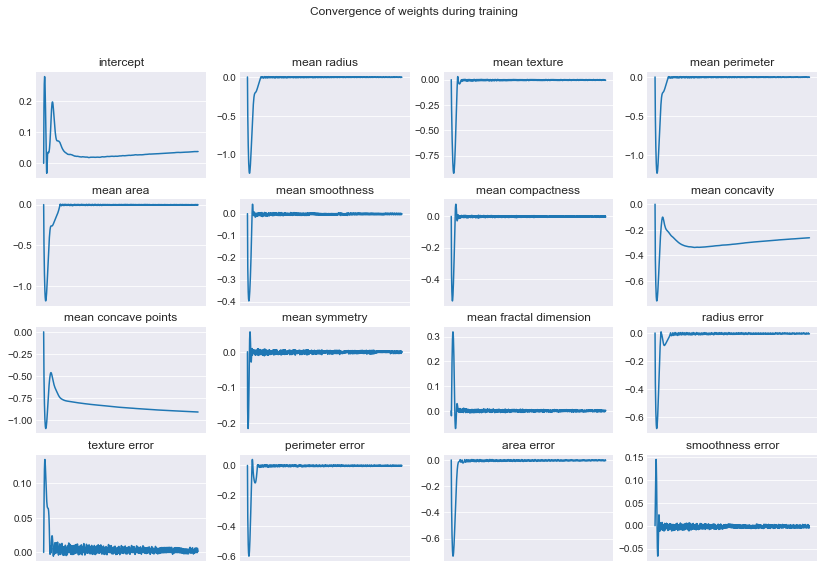

In [13]:
weights = np.asarray(weights)
n_iterations, n_features = weights.shape
nrows = 4
ncols = 4
_, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 9))
for i, j in product(range(nrows), range(ncols)):
    k = nrows * i + j
    w = weights[:, k]
    label = "intercept" if k == 0 else data.feature_names[k - 1]
    axes[i, j].plot(np.arange(n_iterations), w, label=label)
    axes[i, j].set_title(label)
    axes[i, j].get_xaxis().set_visible(False)
plt.suptitle("Convergence of weights during training")
plt.show()
plt.close()

Lastly, we report this third model's accuracy on the training and testing data.

In [14]:
pred_train = clf_l1.predict(x_train)
pred_test = clf_l1.predict(x_test)
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f"Training accuracy: {accuracy_train:.4f}")
print(f"Testing accuracy:  {accuracy_test:.4f}")

Training accuracy: 0.9895
Testing accuracy:  0.9718
